# Продажи австралийского вина

In [3]:
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa as tsa
%pylab inline

from matplotlib import rc
rc('font',**{'family':'serif', 'size':70})
rc('text', usetex=True)
rc('text.latex',unicode=True)
rc('text.latex',preamble='\usepackage[utf8]{inputenc}')
rc('text.latex',preamble='\usepackage[russian]{babel}')

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


Известны ежемесячные продажи австралийского вина в тысячах литров с января 1980 по июль 1995, необходимо построить прогноз на следующие два года.

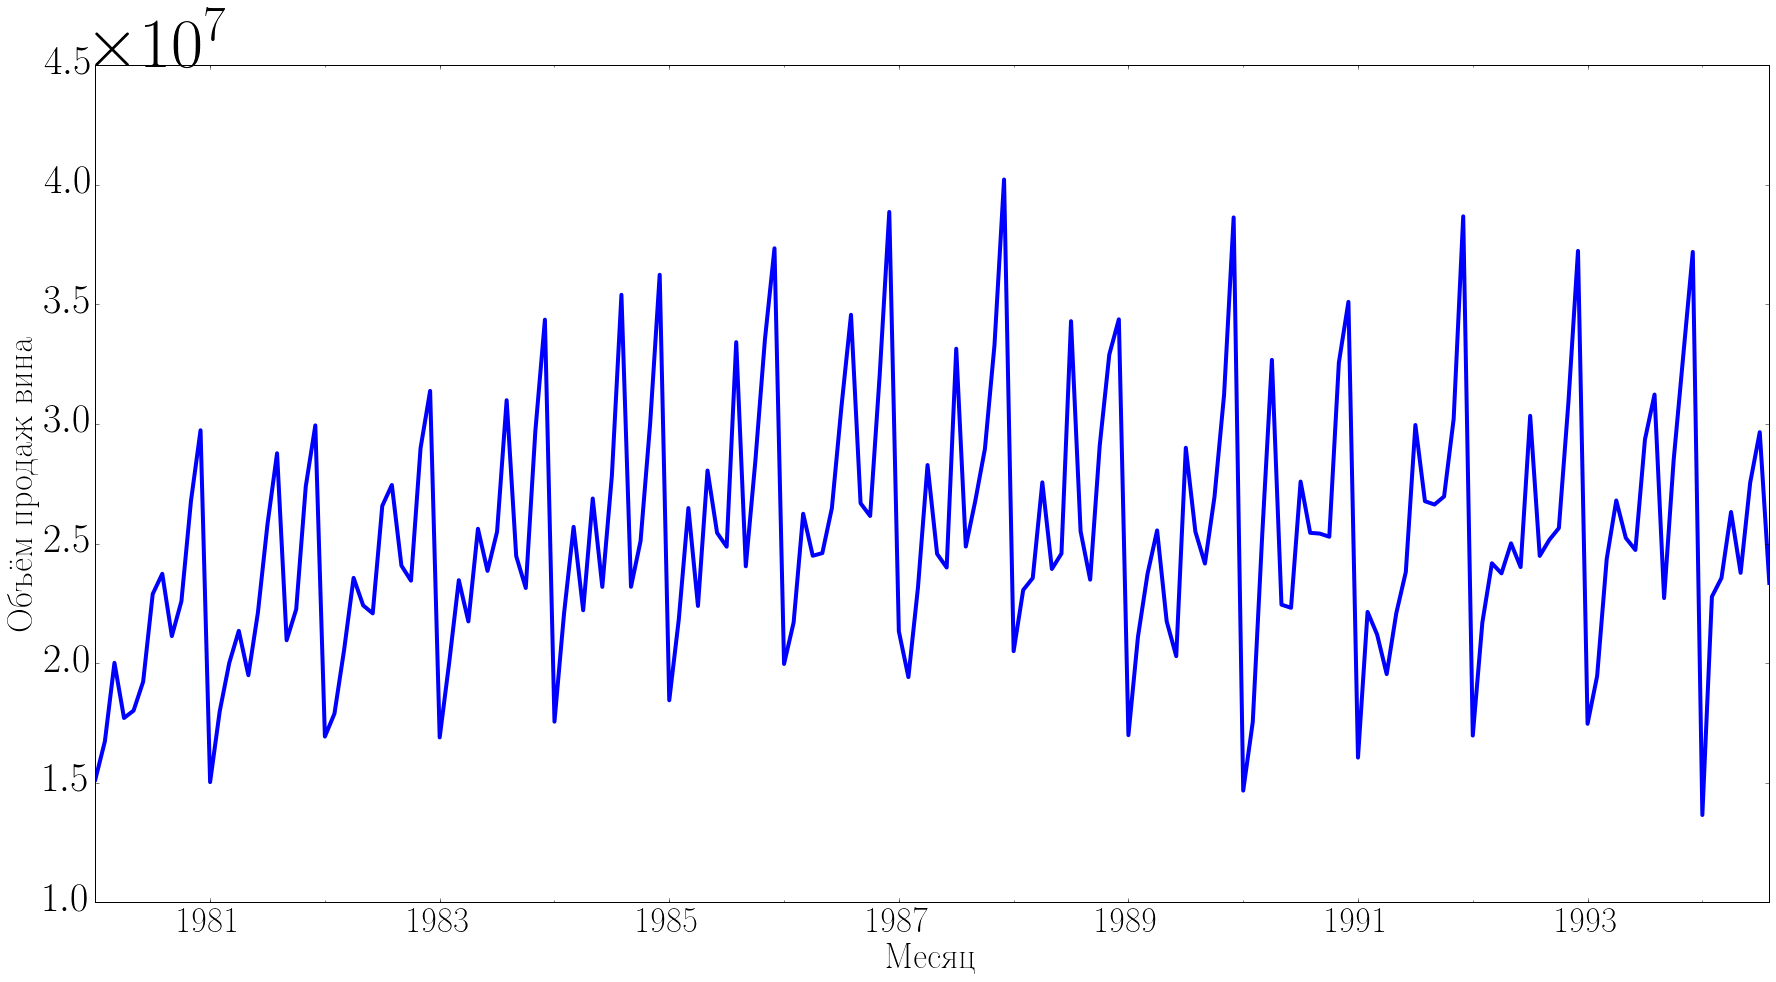

In [6]:
wine = pd.read_csv('monthly-australian-wine-sales.csv',',', index_col=['month'], parse_dates=['month'], dayfirst=True)
wine.sales = wine.sales * 1000
plt.figure(figsize(30,15))
wine.sales.plot(fontsize=40, linewidth=4.0)
plt.xlabel(u'Месяц', fontsize=60)
plt.ylabel(u'Объём продаж вина', fontsize=60)

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.051161


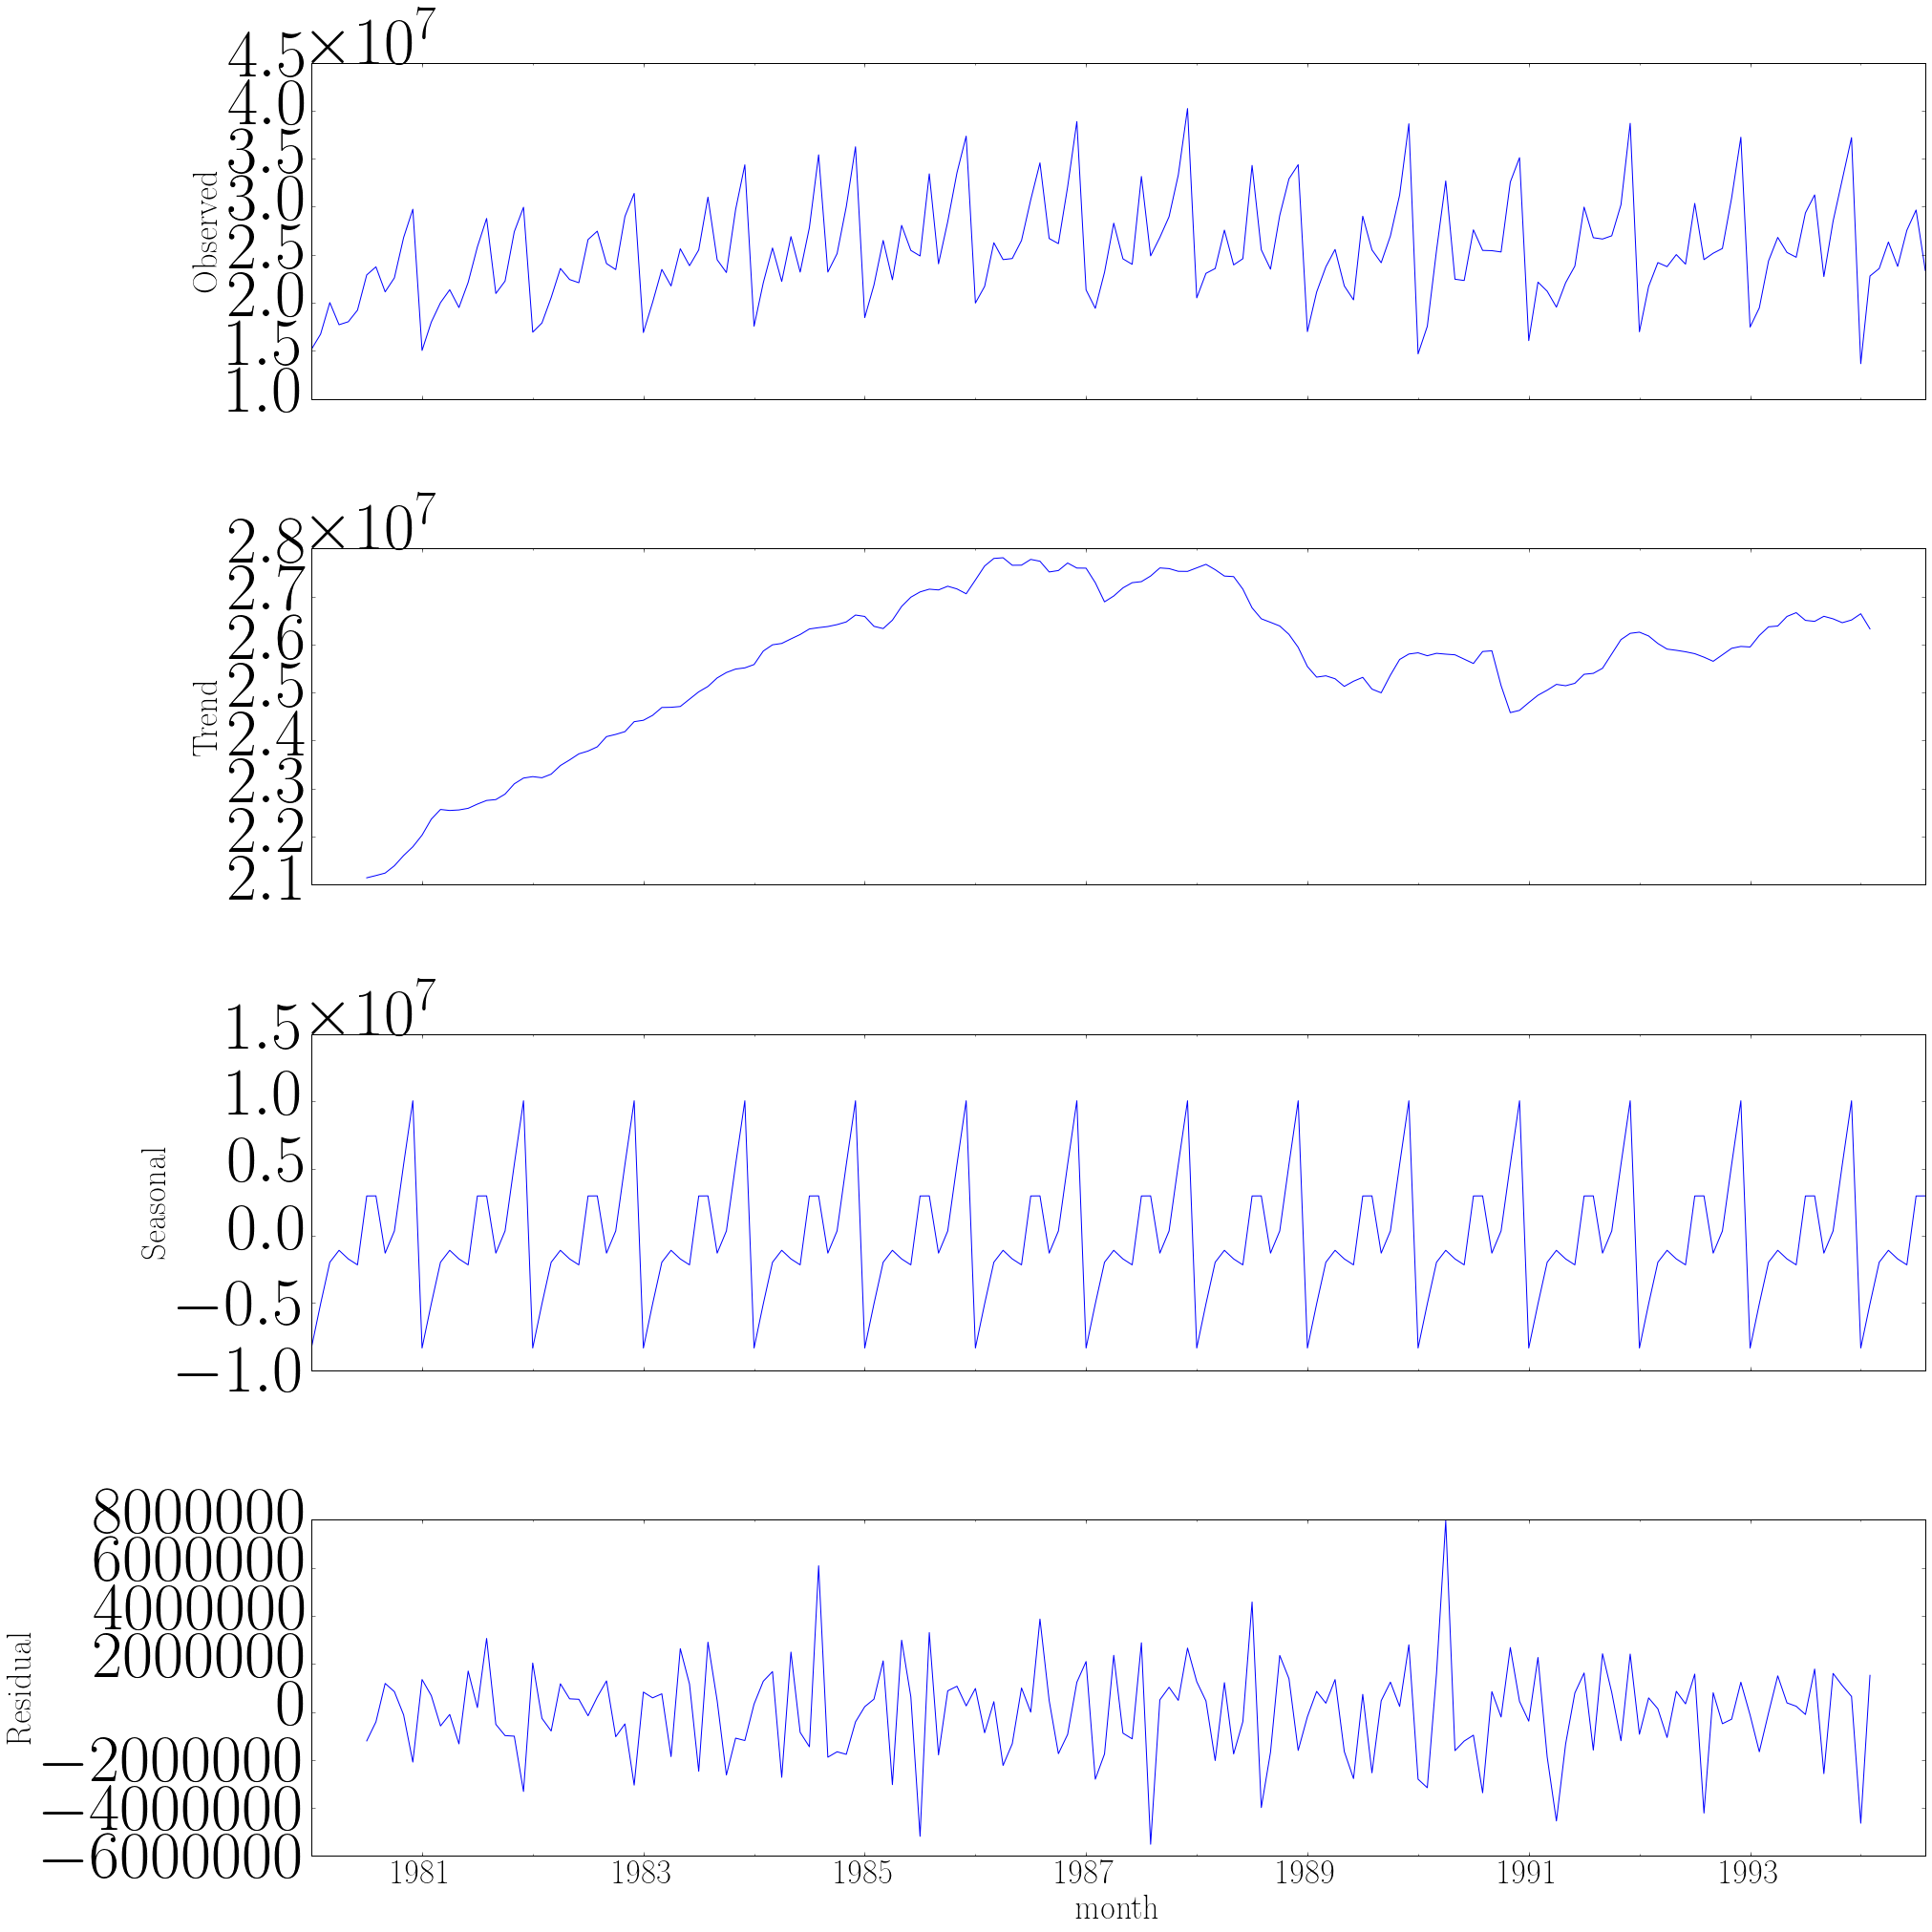

In [38]:
plt.figure(figsize(30,30))
sm.tsa.seasonal_decompose(wine.sales).plot()
print "Критерий Дики-Фуллера: p=%f" % tsa.stattools.adfuller(wine.sales)[1]

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

### Стабилизация дисперсии

Оптимальный параметр преобразования Бокса-кокса: 0.236675
Критерий Дики-Фуллера: p=0.029565


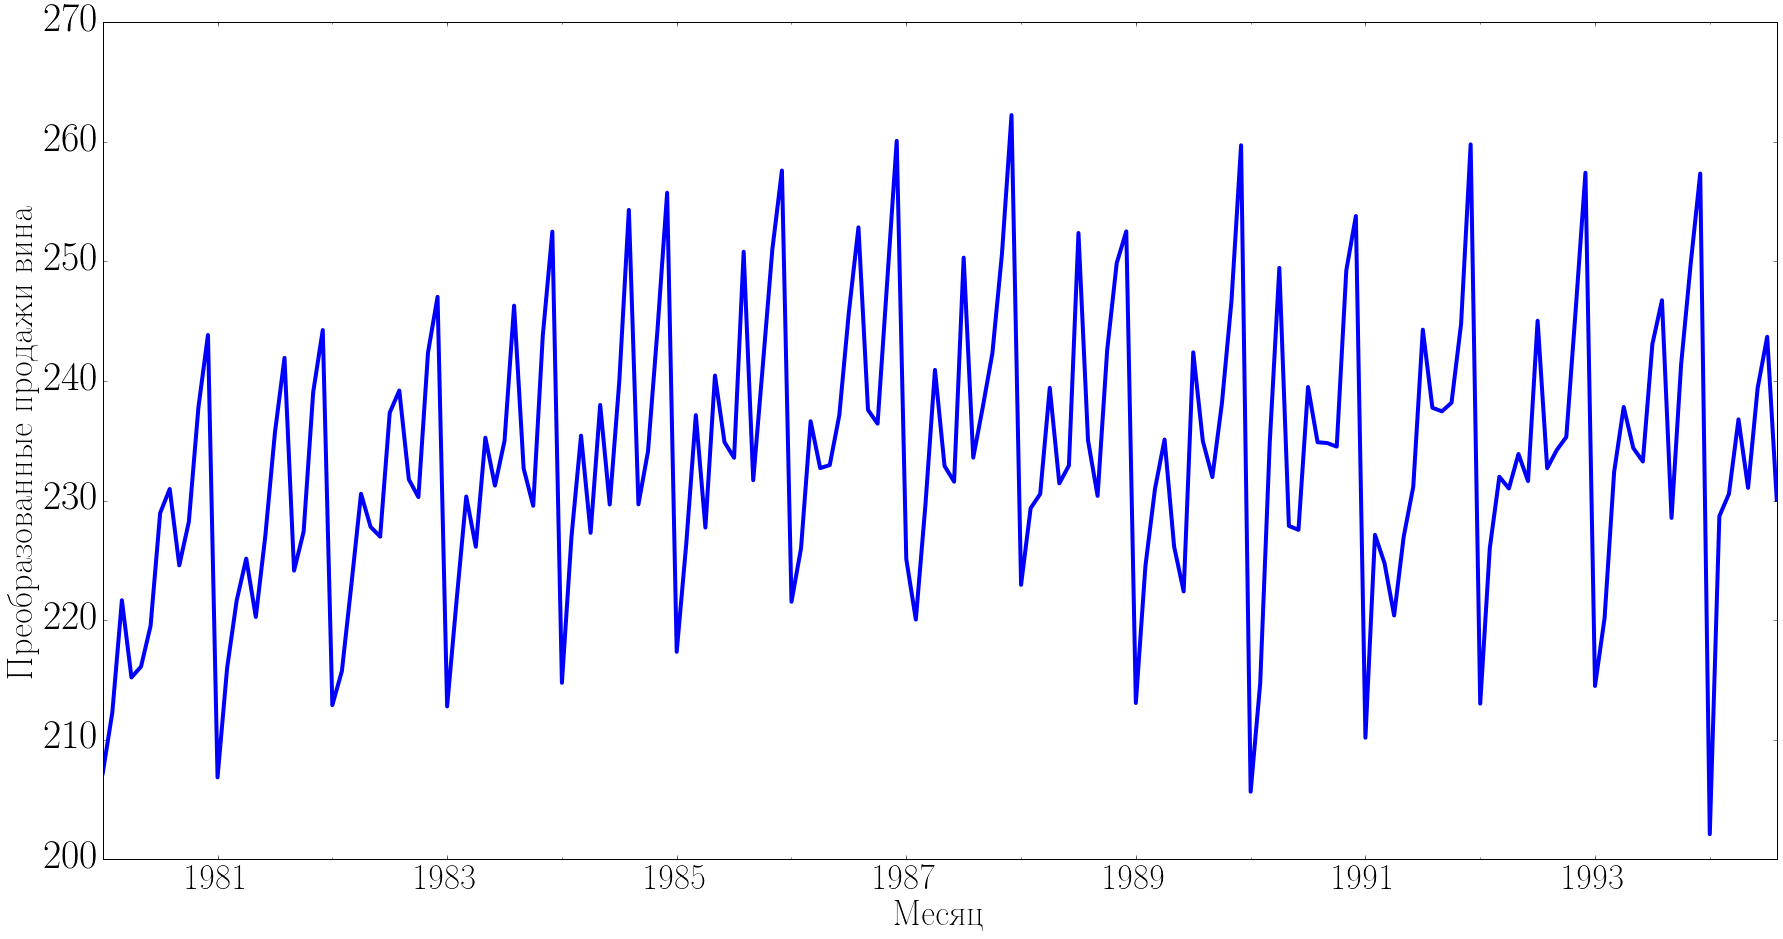

In [39]:
wine['sales_box'], lmbda = stats.boxcox(wine.sales)
plt.figure(figsize(30,15))
wine.sales_box.plot(fontsize=40, linewidth=4.0)
plt.xlabel(u'Месяц', fontsize=60)
plt.ylabel(u'Преобразованные продажи вина', fontsize=60)
print "Оптимальный параметр преобразования Бокса-кокса: %f" % lmbda
print "Критерий Дики-Фуллера: p=%f" % tsa.stattools.adfuller(wine.sales_box)[1]

### Стационарность

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.128317


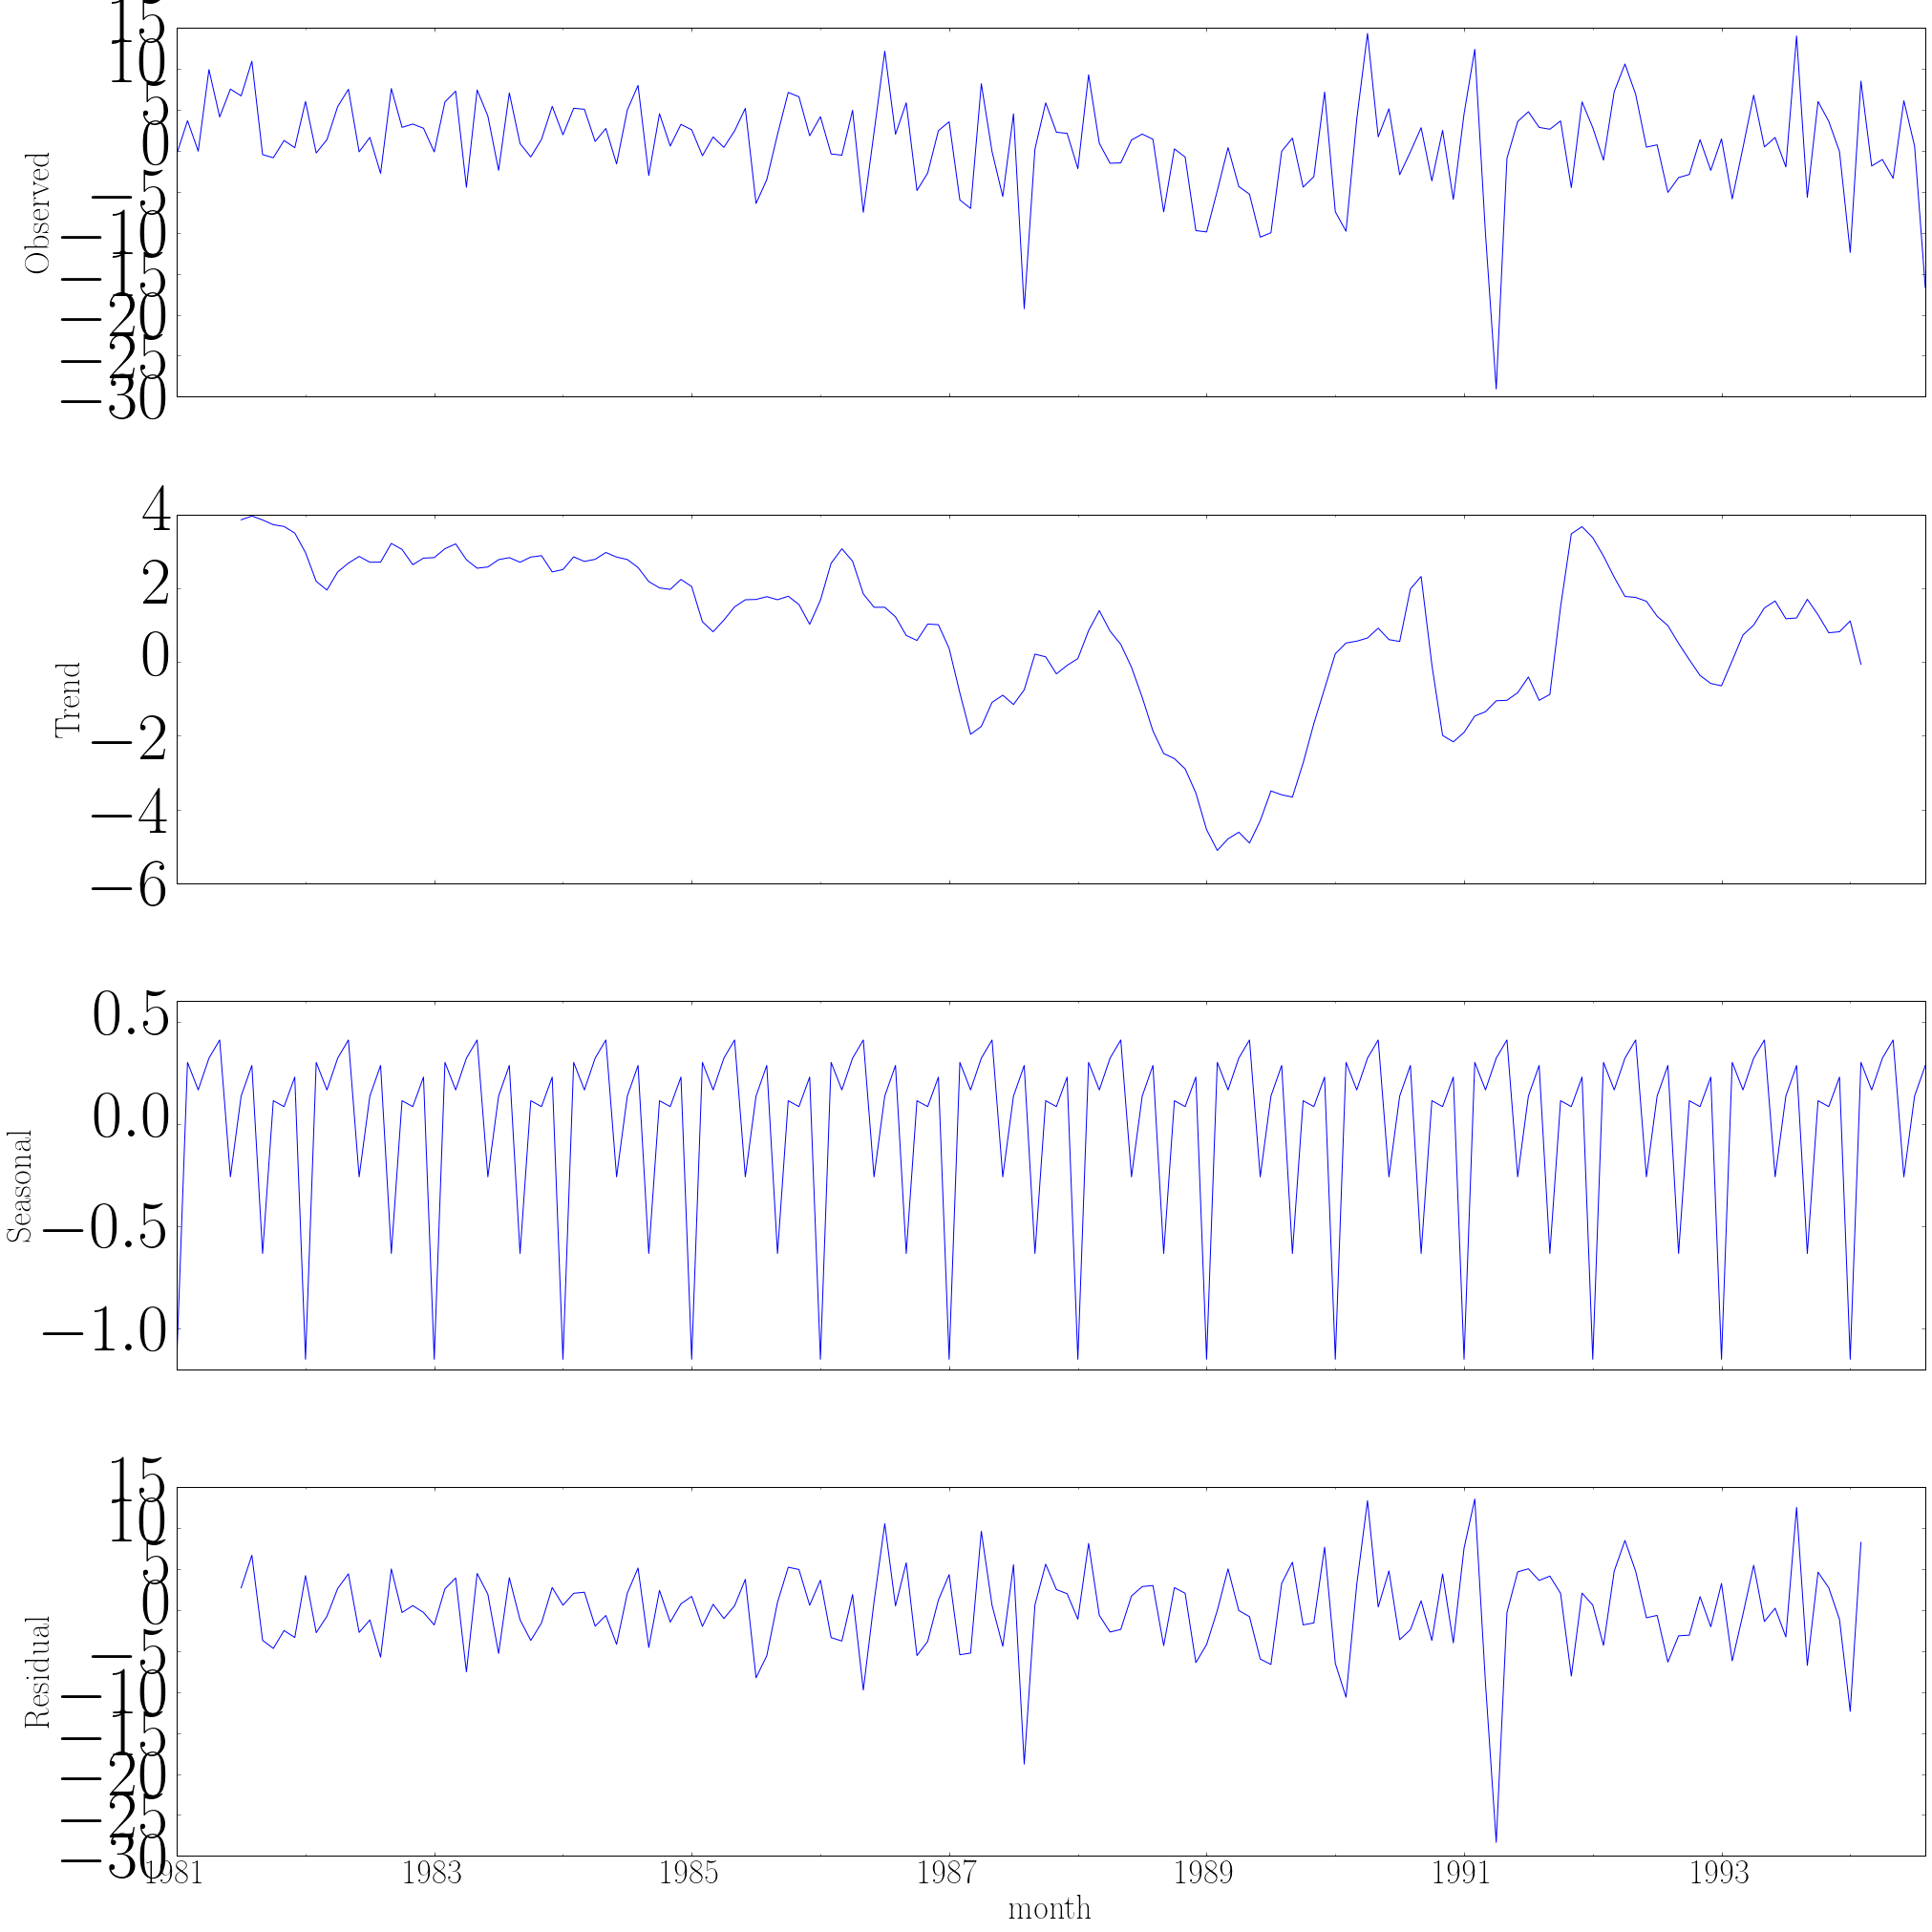

In [37]:
wine['sales_box_diff'] = wine.sales_box - wine.sales_box.shift(12)
plt.figure(figsize(30,30))
sm.tsa.seasonal_decompose(wine.sales_box_diff[12:]).plot()
print "Критерий Дики-Фуллера: p=%f" % tsa.stattools.adfuller(wine.sales_box_diff[12:])[1]

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, и полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.000002


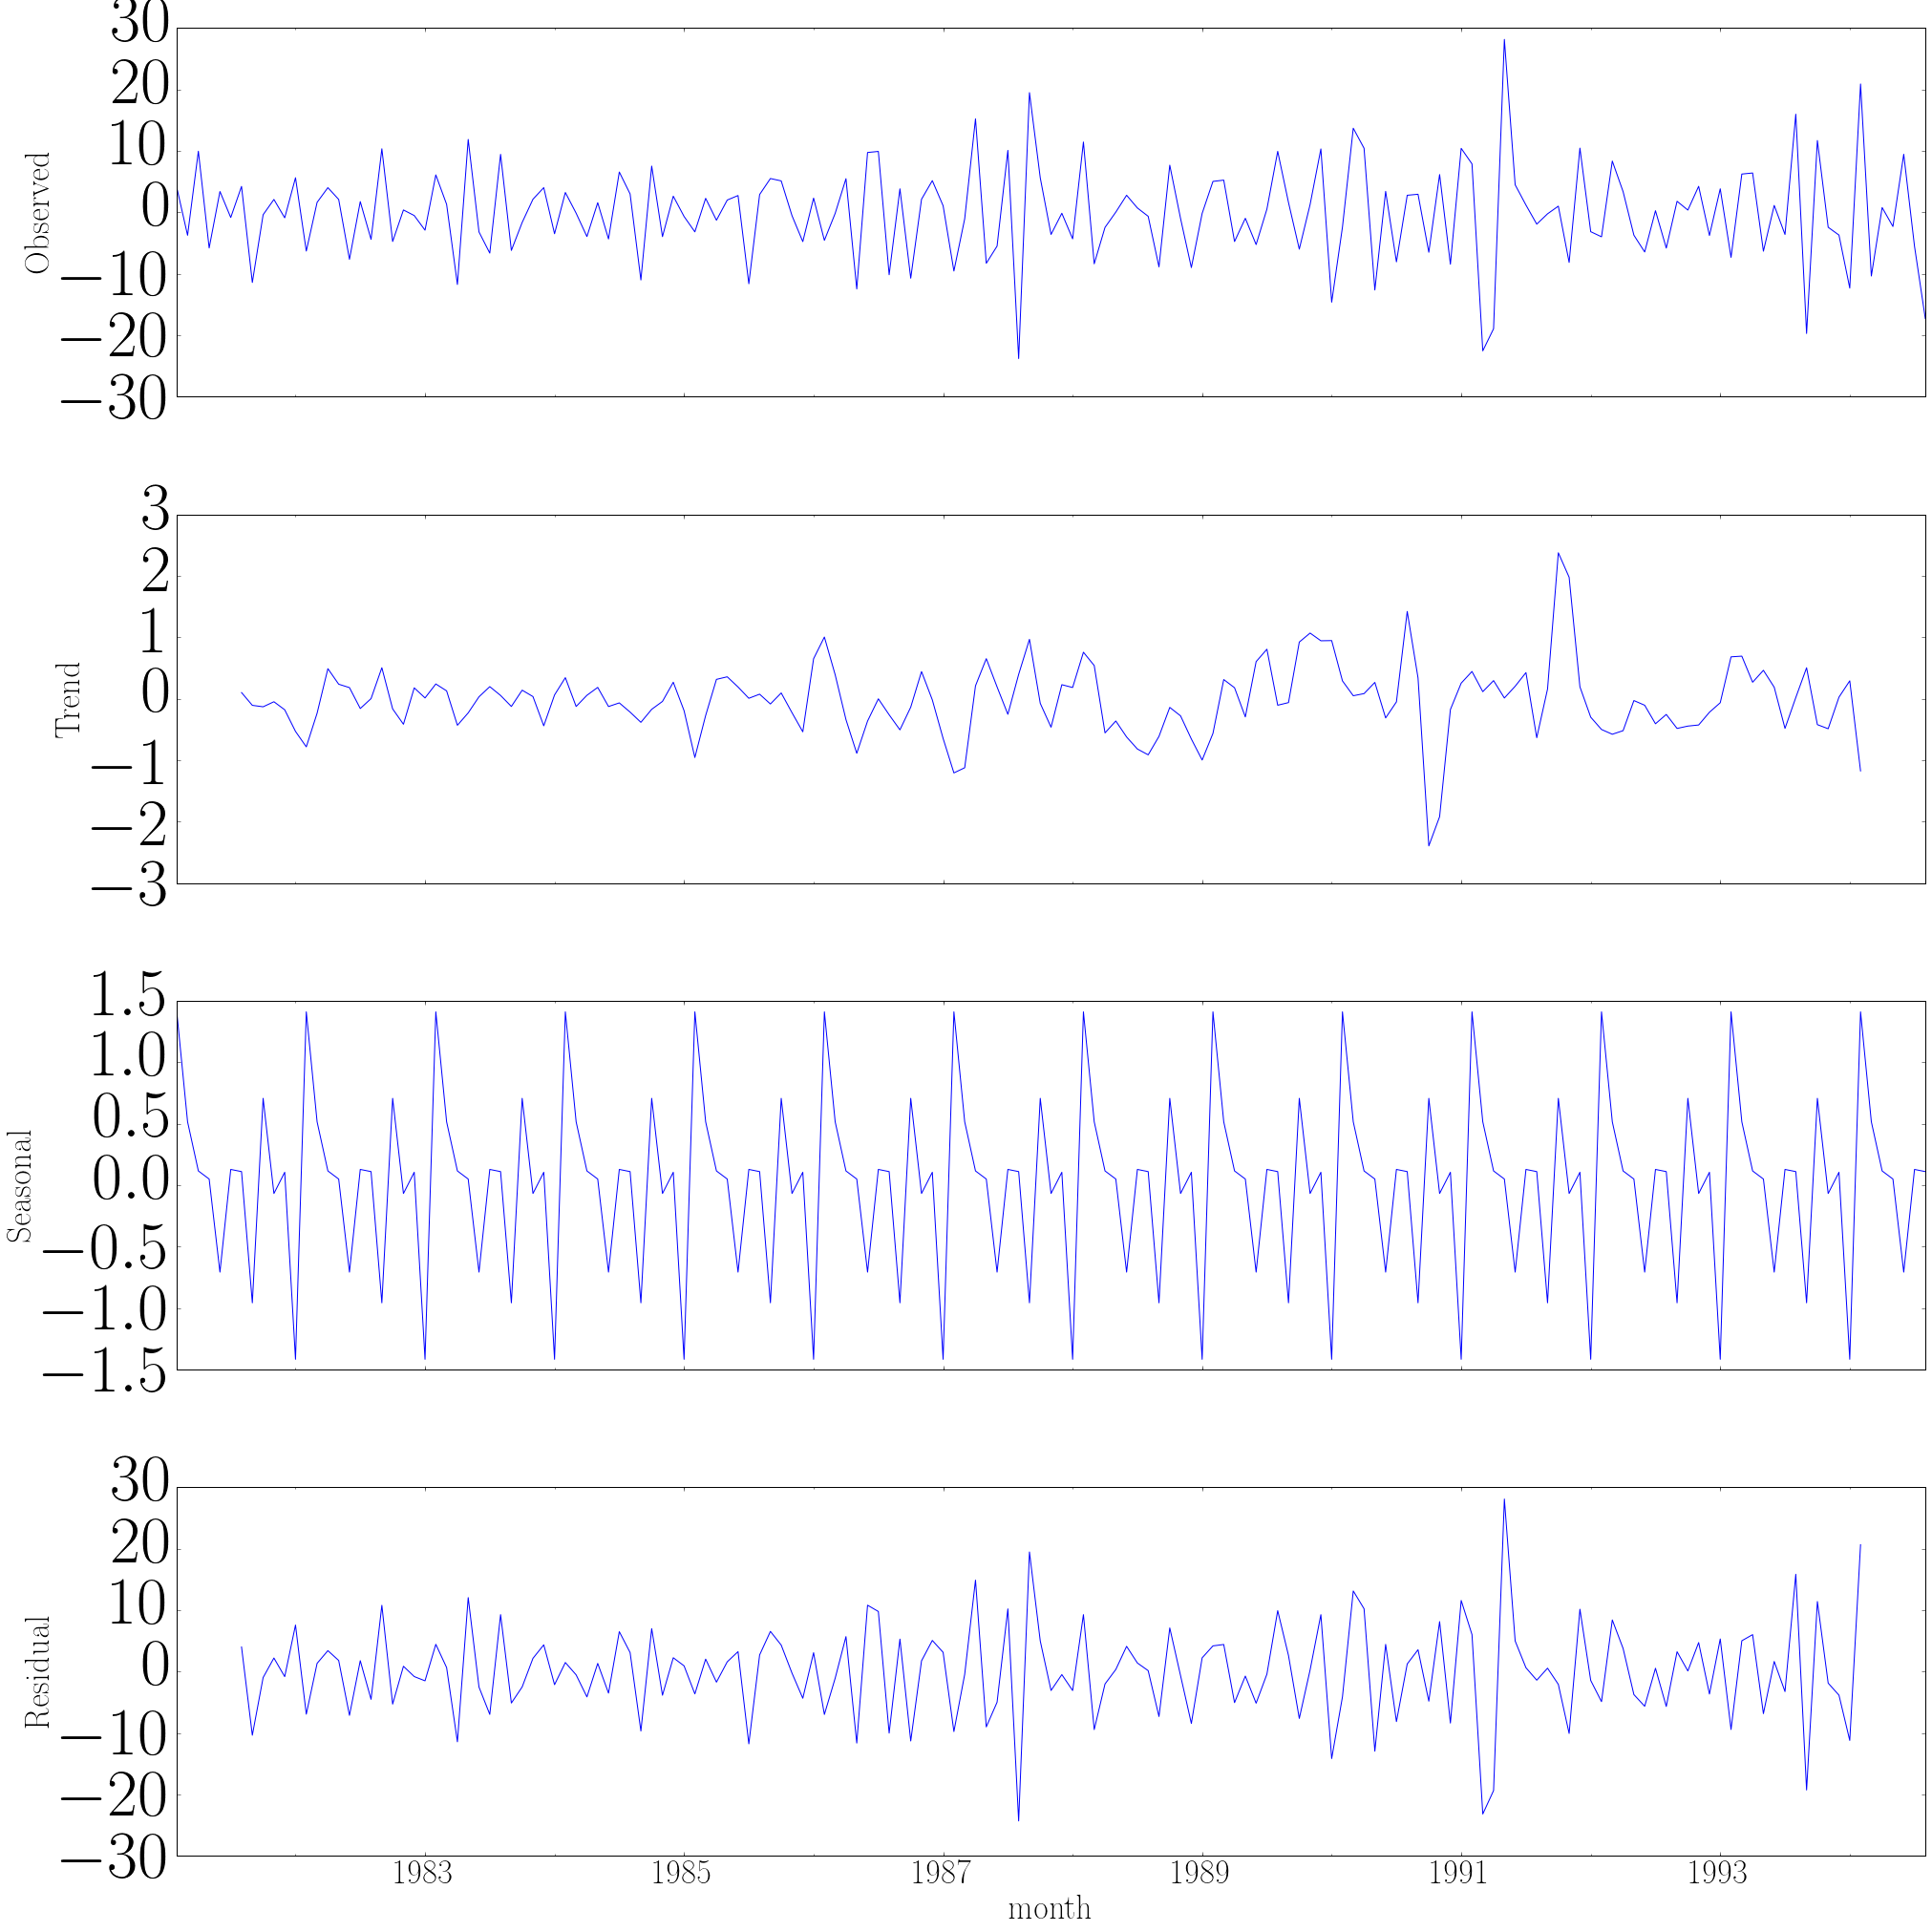

In [36]:
wine['sales_box_diff2'] = wine.sales_box_diff - wine.sales_box_diff.shift(1)
plt.figure(figsize(30,30))
sm.tsa.seasonal_decompose(wine.sales_box_diff2[13:]).plot()   
print "Критерий Дики-Фуллера: p=%f" % tsa.stattools.adfuller(wine.sales_box_diff2[13:])[1]

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет. 

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

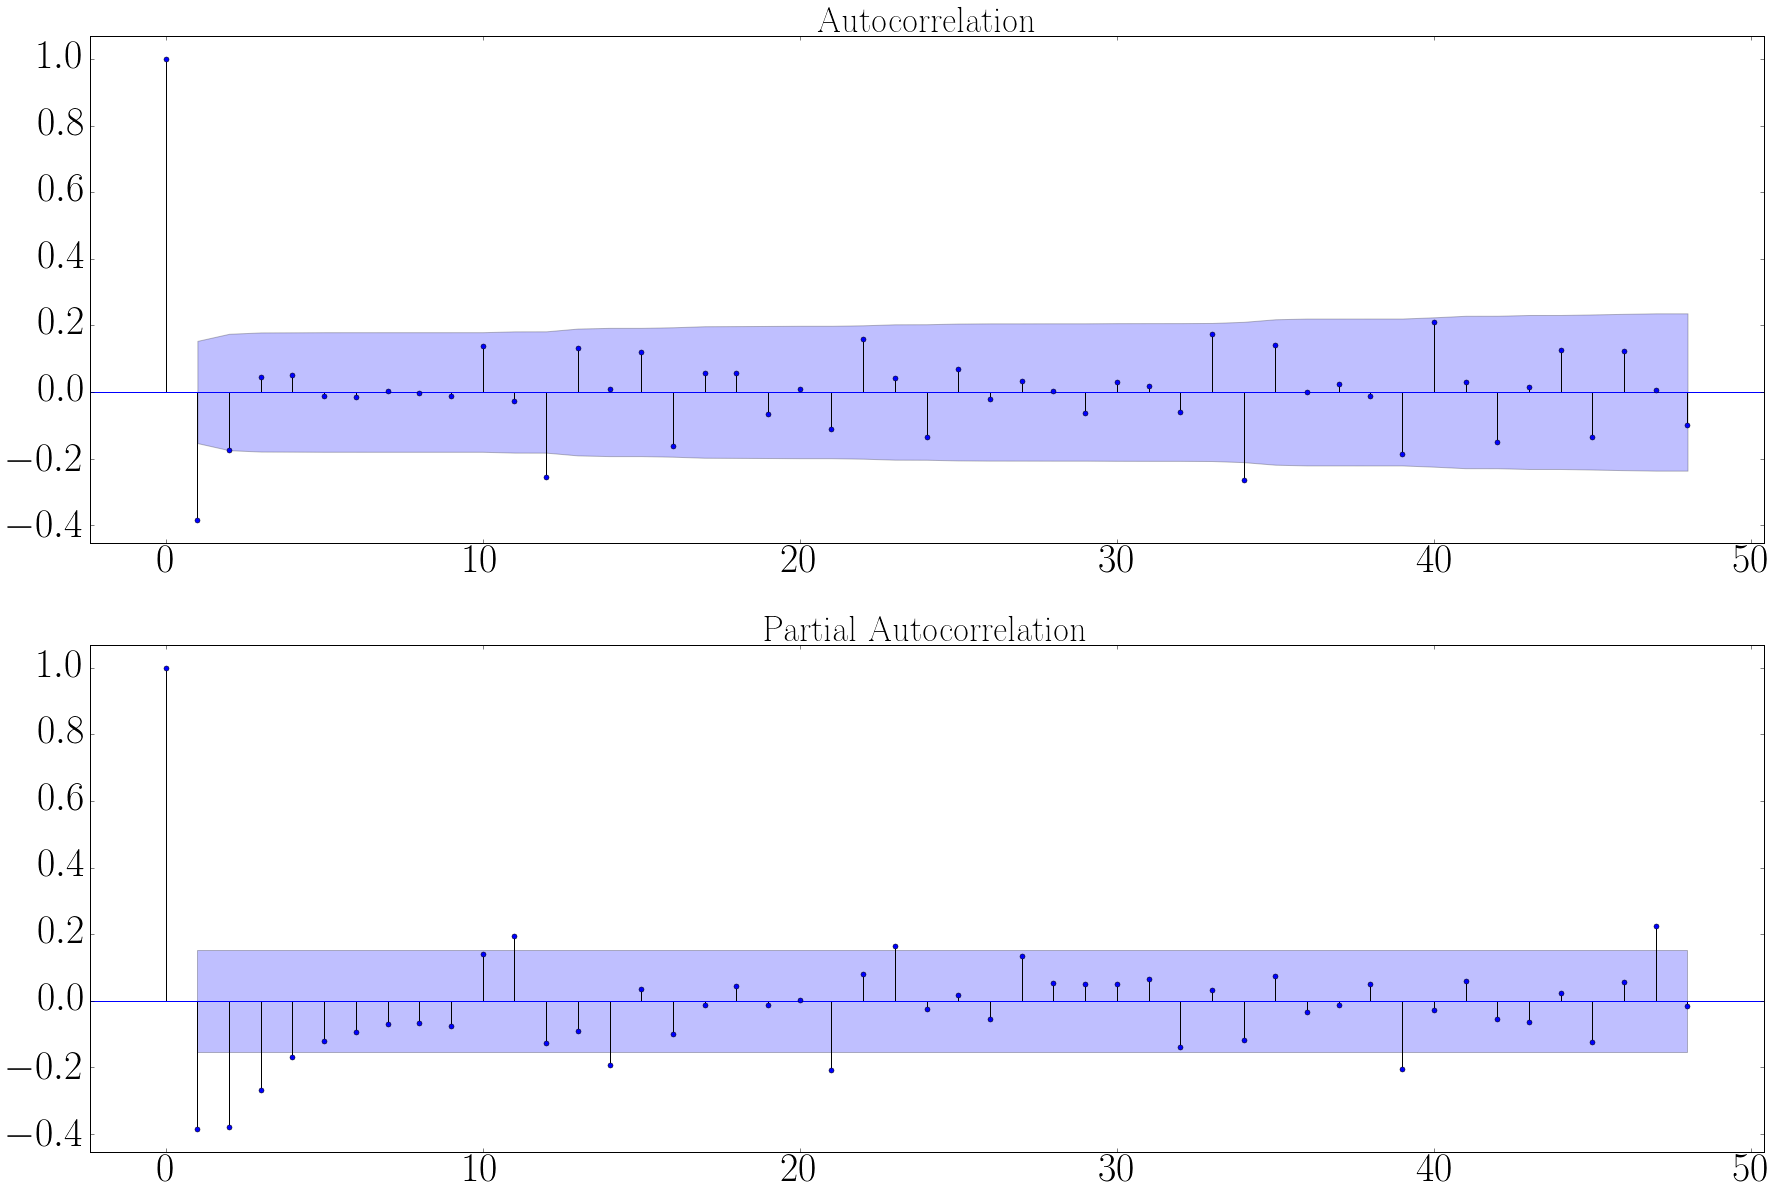

In [40]:
plt.figure(figsize(30,20))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(wine.sales_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(40)

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(wine.sales_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(40)

Начальные приближения: Q=1, q=2, P=1, p=4

In [54]:
Ps = range(0, 3)
ps = range(0, 6)
Qs = range(0, 3)
qs = range(0, 4)

In [94]:
model=sm.tsa.statespace.SARIMAX(wine.sales_box, order=(2, 1, 1), seasonal_order=(0, 1, 1, 12)).fit(disp=-1)

In [99]:
model.aic

1007.8015532017951

Лучшая модель:

In [95]:
print model.summary()

                                 Statespace Model Results                                 
Dep. Variable:                          sales_box   No. Observations:                  176
Model:             SARIMAX(2, 1, 1)x(0, 1, 1, 12)   Log Likelihood                -498.901
Date:                            Wed, 14 Sep 2016   AIC                           1007.802
Time:                                    13:56:15   BIC                           1023.654
Sample:                                01-01-1980   HQIC                          1014.231
                                     - 08-01-1994                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1506      0.085     -1.763      0.078      -0.318       0.017
ar.L2         -0.1990      0.111   

Её остатки:

Критерий Стьюдента: p=0.257989
Критерий Дики-Фуллера: p=0.000000


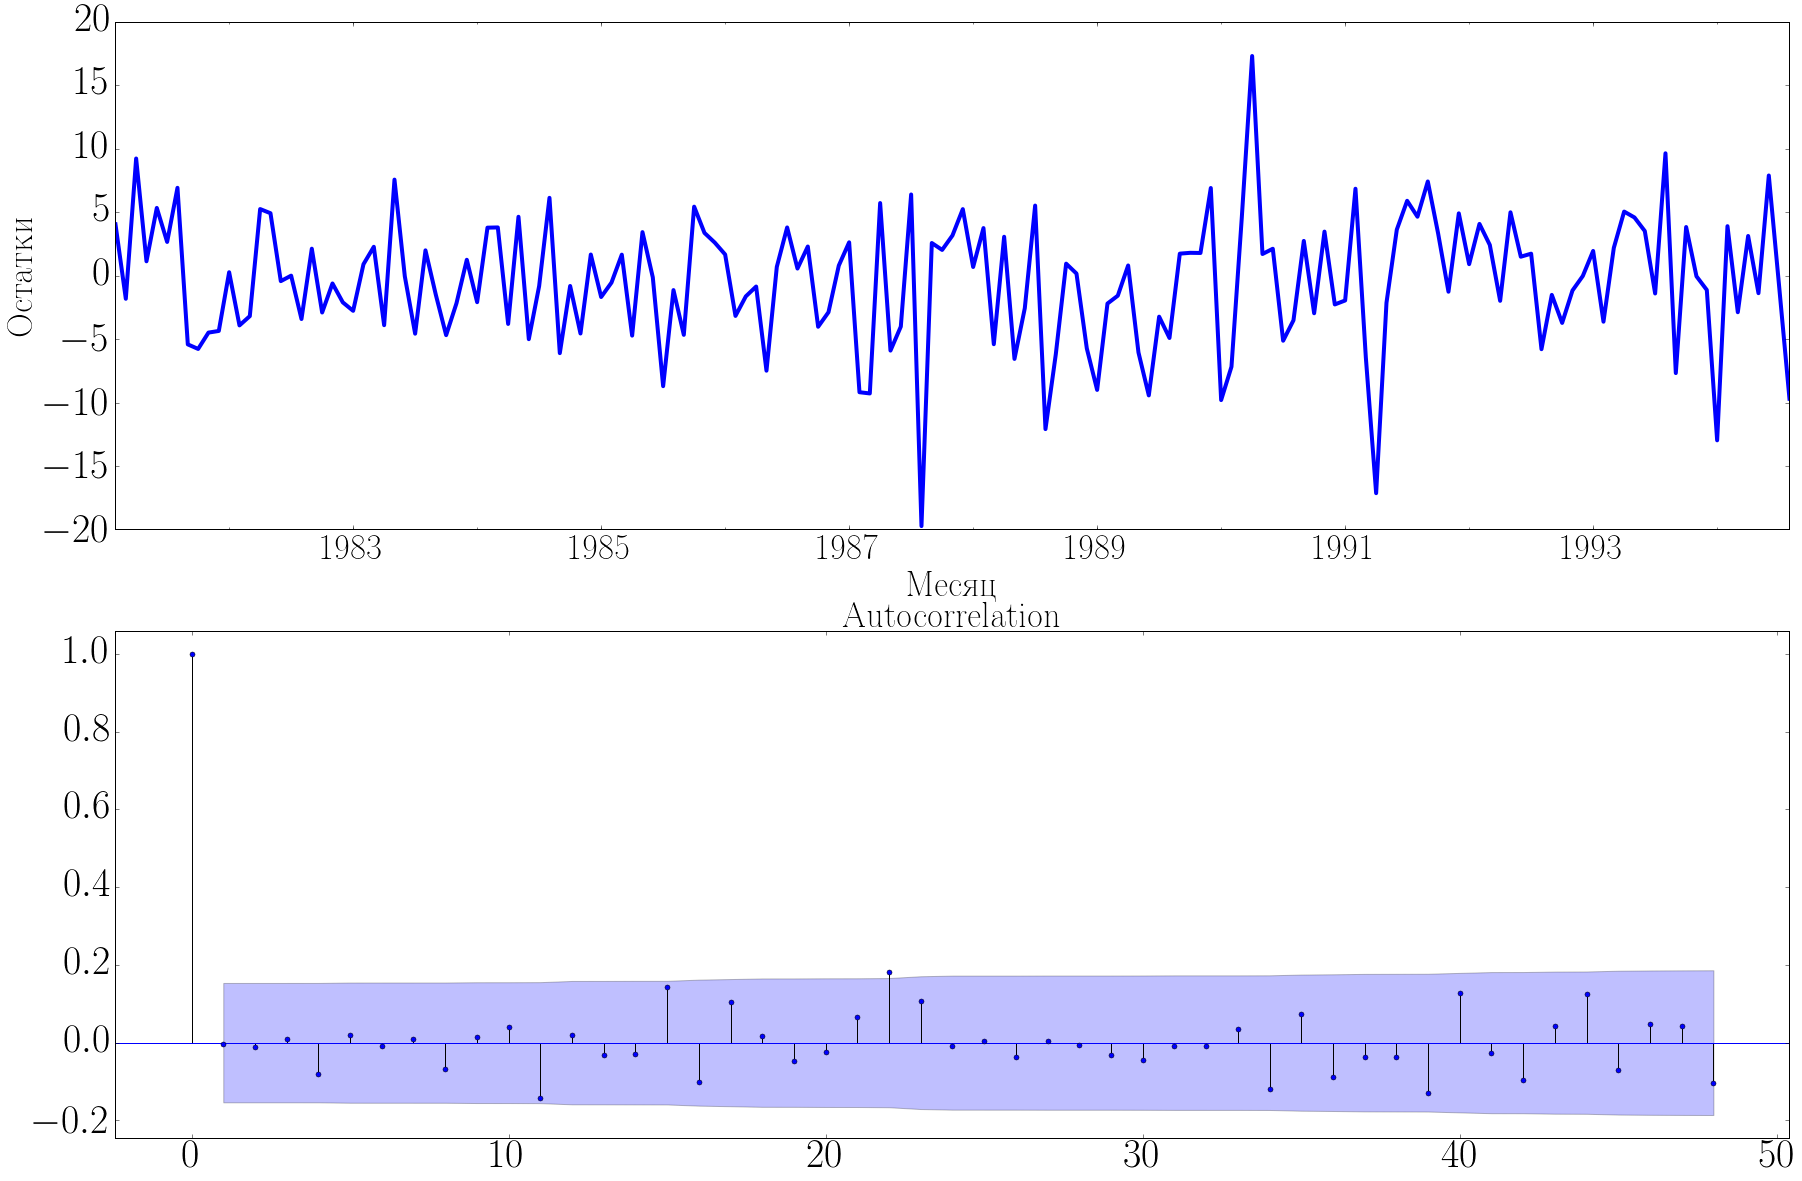

In [96]:
plt.figure(figsize(30,20))
plt.subplot(211)
model.resid[13:].plot(fontsize=40, linewidth=4.0)
plt.xlabel(u'Месяц', fontsize=60)
plt.ylabel(u'Остатки', fontsize=60)

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(model.resid[13:].values.squeeze(), lags=48, ax=ax)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(40)

print "Критерий Стьюдента: p=%f" % stats.ttest_1samp(model.resid[13:], 0)[1]
print "Критерий Дики-Фуллера: p=%f" % tsa.stattools.adfuller(model.resid[13:])[1]

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

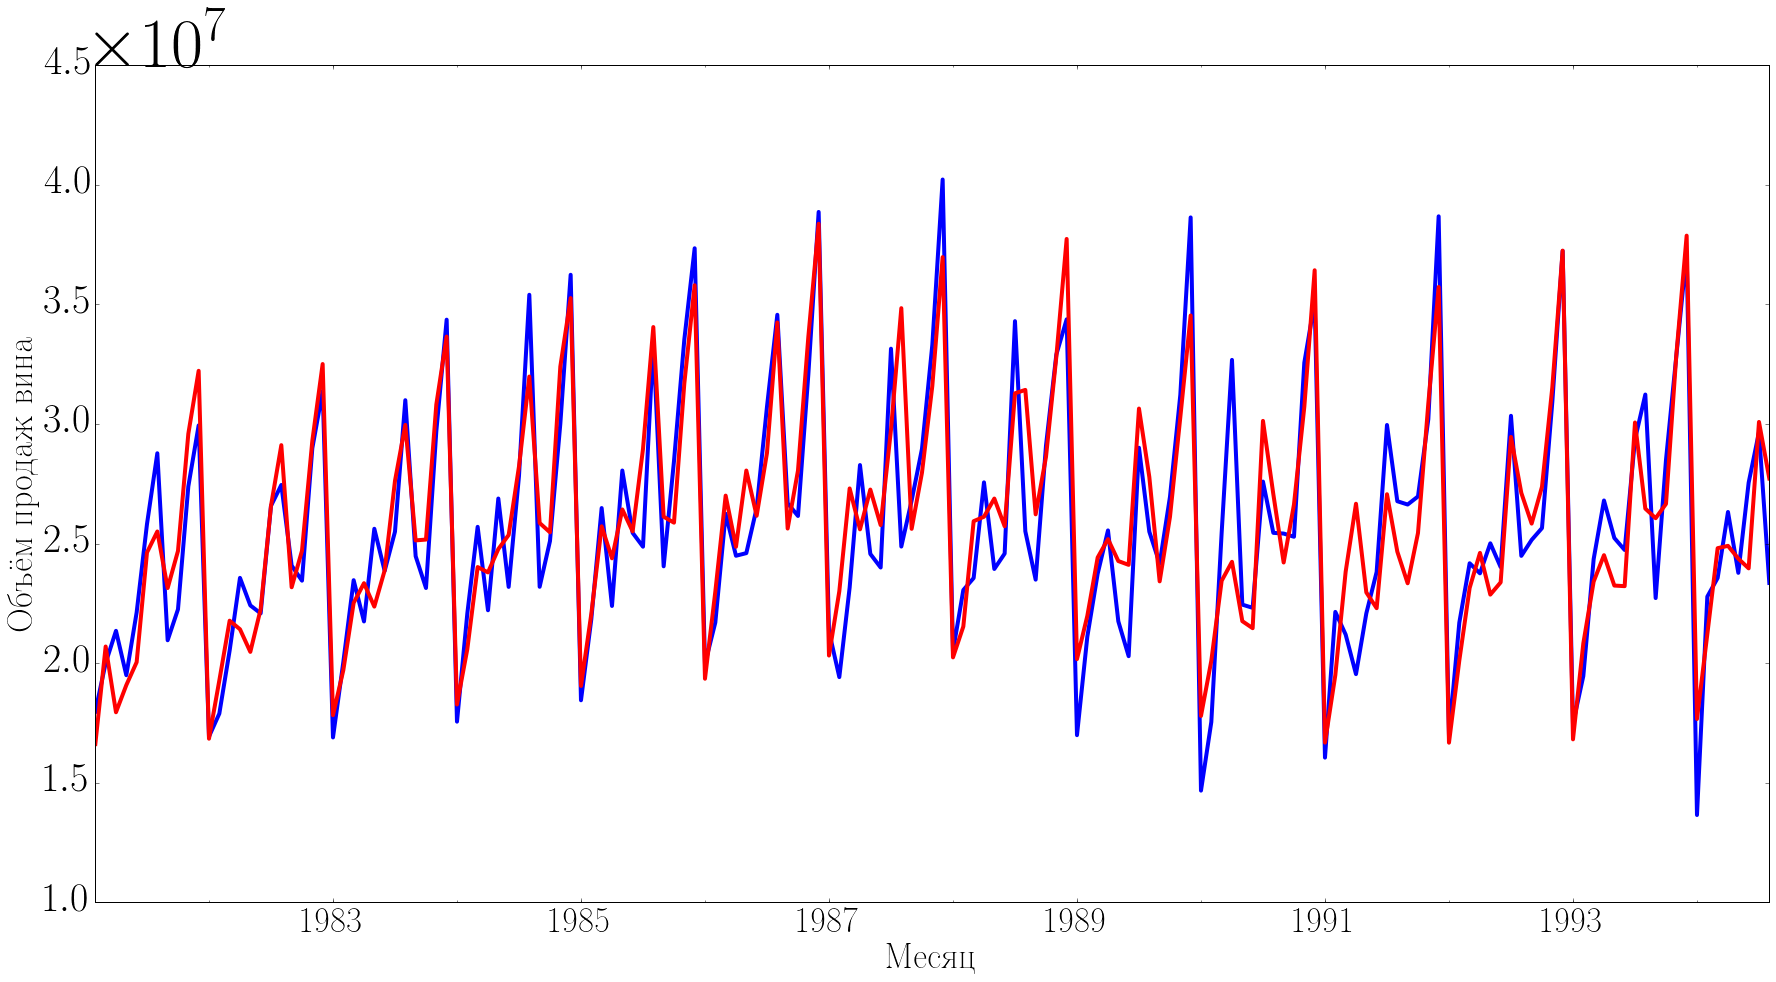

In [97]:
wine['model'] = invboxcox(model.fittedvalues, lmbda)
plt.figure(figsize(30,15))
wine.sales[13:].plot(fontsize=40, linewidth=4.0)
wine.model[13:].plot(fontsize=40, linewidth=4.0, color='r')
plt.xlabel(u'Месяц', fontsize=60)
plt.ylabel(u'Объём продаж вина', fontsize=60)

### Прогноз

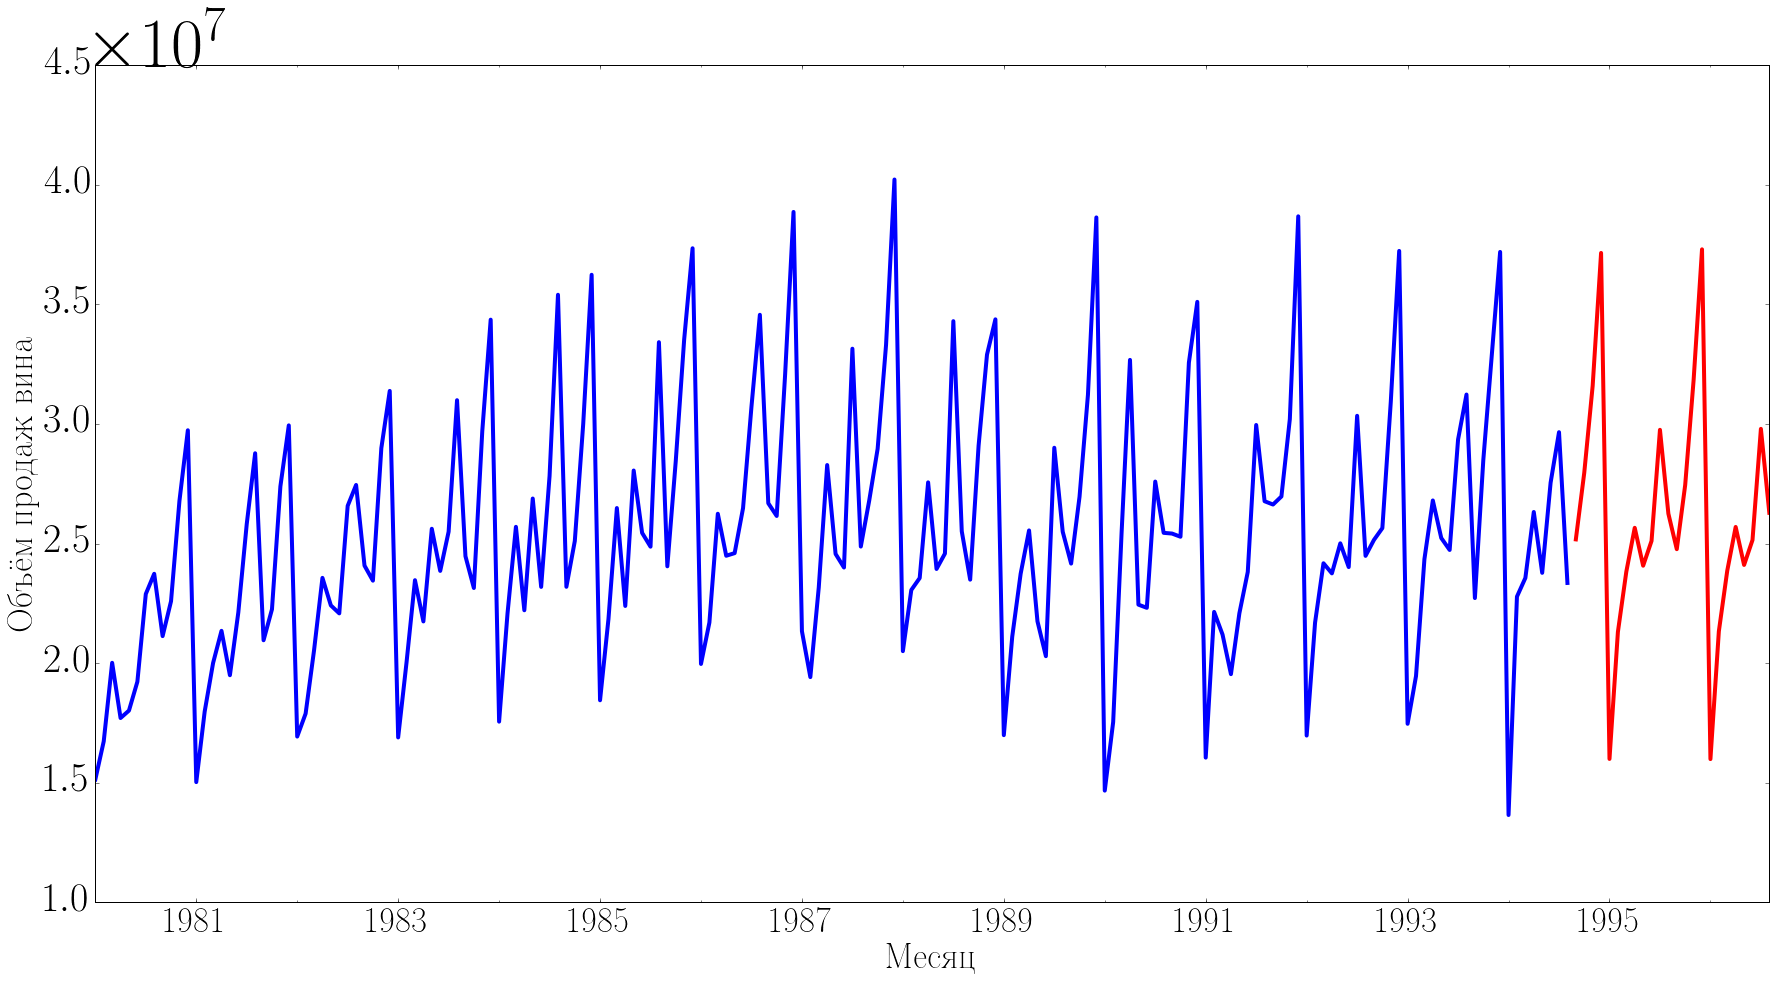

In [98]:
wine2 = wine[['sales']]
date_list = [datetime.datetime.strptime("1994-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0,24)]
future = pd.DataFrame(index=date_list, columns= wine2.columns)
wine2 = pd.concat([wine2, future])
wine2['forecast'] = invboxcox(model.predict(start=176, end=199), lmbda)

plt.figure(figsize(30,15))
wine2.sales.plot(fontsize=40, linewidth=4.0)
wine2.forecast.plot(fontsize=40, linewidth=4.0, color='r')
plt.xlabel(u'Месяц', fontsize=60)
plt.ylabel(u'Объём продаж вина', fontsize=60)